# Bias and Variance
## Foundations of Machine Learning
## `! git clone https://www.github.com/DS3001/bias_and_variance`

## Building Linear Models
- Random Forests are a modern way to resolve our problems with Decision Trees: Use randomization to create a huge number of fairly low powered trees, and then average them to get a lower variance and higher accuracy predictor
- We're going to spend two classes addressing some of the issues with linear models, to bring your toolbox up to a similarly modern standard
- Many of the principles can be applied to $k$NN and $k$MC, which have similar model selection questions

## Linear Model Review
- We have a relationship between an outcome $y$ and feature/explanatory/predictor variables $x$, 
$$
y_i = b \cdot x_i = \underbrace{b_0}_{\text{Constant/Intercept}} + \sum_{k=1}^L \underbrace{b_k}_{\text{Slope}} x_{ik}
$$
- The coefficients/weights are typically chosen to minimize the *Sum of Squared Error*,
$$
\text{SSE}(b) = \sum_{i=1}^N \left( y_i - b \cdot x_i \right)^2
$$
- The optimal $b$ is called the *Ordinary Least Squares* or OLS estimator ($\hat{b} = (X'X)^{-1}(X'y)$)

## Underfitting and Overfitting
- What happens when we use "too few" or "too many" variables in building a linear model?
- In the case of linear models, we can explore the consequences of ommitting variables that should arguably be in the model (underfitting) and adding too many variable (overfitting)
    - Underfitting: When we leave out variables, we get a phenomenon called **omitted variables bias**, where the coefficients in the model adjust to compensate for missing variables
    - Overfitting: When we include too many variables, we get a phenomenon called **multicolinearity** or **bad control**, where the variables are competing to explain the same variation in $y$ and "get in each other's way," resulting in a low quality model

## Omitted Variables Bias
- What happens when you move variables in and out of a regression?
- Suppose there's a "true model," 
$$
y_i = b_0 + b_1 x_{i1} + b_2 x_{i2} + \varepsilon_i$$
where $\text{cov}(\varepsilon_i,x_{i1})=0$ and $\text{cov}(\varepsilon_i,x_{i2})=0$; the regressors are "exogenous" or "pre-determined"
- If the the two variables $x_1$ and $x_2$ are correlated, they both explain some of the same variation in $y$; if you drop one, the other will become a stronger predictor.
- But if you drop one of the variables, say $x_2$, you introduce *bias* in the estimation of $b_1$ relative to the true value of $b_1$: You're not explaining all of the variation in $y$ that $x_2$ explained, and the model will now attribute more power to $x_1$ since it will soak up some of the variation in $y$ that $x_2$ explained

## Omitted Variables Bias [Math]
- But if you regress $y$ on $x_1$ alone, the OLS coefficient is 
\begin{eqnarray*}
\hat{b}_1 &=& \dfrac{\text{cov}(y,x_1)}{\text{var}(x_1)} \\
&=& \dfrac{\text{cov}(b_0 + b_1 x_1 + b_2 x_2+\varepsilon,x_1)}{\text{var}(x_1)} \\
&=& \dfrac{b_1 \text{cov}(x_1,x_1) + b_2 \text{cov}(x_2,x_1)+\text{cov}(\varepsilon,x_1)}{\text{var}(x_1)} \\
&=& b_1 \underbrace{\dfrac{\text{cov}(x_1,x_1)}{\text{var}(x_1)}}_{=1} + b_2 \dfrac{\text{cov}(x_2,x_1) }{\text{var}(x_1)}+ \underbrace{\dfrac{\text{cov}(\varepsilon,x_1)}{\text{var}(x_1)}}_{=0}
\end{eqnarray*}

## Omitted Variables Bias
- The **omitted variables bias** formula for the above situation is:
$$
\hat{b}_1 = \underbrace{ b_1 }_{\text{``True'' $b_1$ weight}} + \underbrace{b_2}_{\text{``True'' $b_2$ weight}} \quad \underbrace{ \dfrac{ \text{cov}(x_1, x_2) }{ \text{var}(x_2)} }_{\text{Regression weight of $x_1$ on $x_2$}}
$$
- When you drop $x_2$, $x_1$ indirectly picks up exactly the variation in $y$ that is explained by a regression of $x_1$ on $x_2$
- This is often summarized as "correlation is not causation": Regression estimates can rarely be interpreted in a causal sense
- If $\text{cov}(x_1,x_2)=0$, there is no OVB problem because the variables are uncorrelated
- OLS is brilliant: It automatically detects $x_2$'s influence on $y$ through $x_1$, **even if you don't even know $x_2$ exists**

<Axes: >

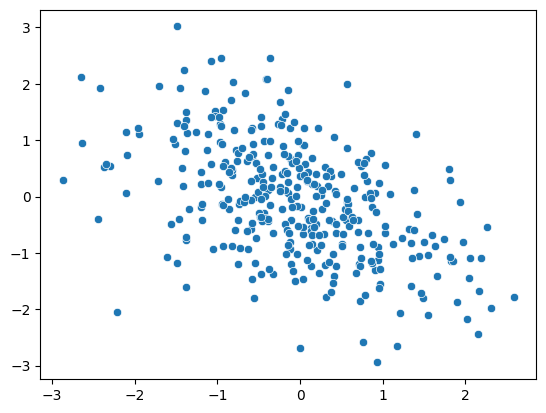

In [1]:
# Quick OVB Laboratory
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

N = 350
K = 2
rho = -.5
mean = [0, 0]
cov = [[1, rho], [rho, 1]] 
x1, x2 = np.random.default_rng().multivariate_normal(mean, cov, N).T
sns.scatterplot(x=x1,y=x2)

In [2]:
beta0 = np.array([8,4,2]) # True coefficients
sigma =2 # Irreducible noise parameter
eps = np.random.default_rng().normal(0, sigma, N).T # Generate shocks
X = pd.DataFrame({'Intercept':np.ones(N), 'x1':x1, 'x2':x2}) # Data frame
y = X @ beta0 + eps # Target variable

In [3]:
from sklearn.linear_model import LinearRegression # Import linear regression model
reg = LinearRegression(fit_intercept=False).fit(X, y) # Fit the linear model
rdf = pd.DataFrame({'variable': X.columns, 'slope':reg.coef_})
rdf

,variable,slope
0,Intercept,8.029389
1,x1,3.958123
2,x2,2.032917


In [4]:
from sklearn.linear_model import LinearRegression # Import linear regression model
Z = pd.DataFrame({'Intercept':np.ones(N), 'x1':x1}) # Data frame
reg_ovb = LinearRegression(fit_intercept=False).fit(Z, y) # Fit the linear model
rdf = pd.DataFrame({'variable': Z.columns, 'slope':reg_ovb.coef_})
rdf

,variable,slope
0,Intercept,7.819875
1,x1,2.916239


In [5]:
# Regress x2 on x1:
VCV = X.loc[:,['x1','x2']].cov()
reg_x2_x1 = VCV.iloc[0,1]/VCV.iloc[0,0]

# Compute OVB:
print(reg.coef_[1] + reg.coef_[2]*reg_x2_x1) # Small sample biased coefficient
beta0[1] + beta0[2]*rho # Theoretical OVB coefficient value

2.9162388365449097


3.0

## Omitted Variables Bias
- From the formula, you can tell which way the bias goes from $\text{cov}(x_1,x_2)$ and $b_2$:
  - $\hat{b}_1$ is biased up if $\text{cov}(x_1,x_2)>0$ and $b_2>0$ or both negative
  - $\hat{b}_1$ is biased down if $\text{cov}(x_1,x_2)<0$ and $b_2>0$ or vice versa
- This can be a helpful check for your intuition when you see unexpected coefficient signs: It could the coefficient, or the covariance

## Examples of Omitted Variables Bias
- Why can't health studies provide basic answers to fundamental questions? (e.g. Are eggs good for you or not? What's the causal effect of drinking/smoking/exercise/elective procedures? What's the OVB problem?)
- Why are there so many poorly designed, low quality studies that get published and publicized? (e.g. "Married people earn higher wages" is a classic. "People who eat ice cream live longer." What's the OVB problem?)
- Does college raise wages? (What's the OVB problem?)
- A lot of "research" is industrialized confirmation bias, which churns out badly estimated correlations and calls it "science"

## Multicolinearity
- The natural response is, "OK, then we should include all the possible explanatory variables to avoid OVB?"
- Unfortunately, it's not that simple: Even if you had all the variables you might want (you never do; e.g. ability, determination, self-control, etc.), there's an infinte number of ways to expand/combine them, and this often leads to a statistical phenomenon called "multicolinearity"
- If some set of variables are correlated, they co-explain each other and the outcome --- the "partialing out" process reduces the explanatory power of each, since there's only so much variation in $y$ to explain with a limited number of $N$ observations
- Remember the OLS coefficient $b_k$ is as if you regressed each of $y$ and $x_k$ on all of the other variables, and then regressed the residuals of $y$ and $x_k$ on one another
- If two explanatory/feature variables are highly correlated, they "get in each other's way" in trying to explain the data: Coefficients become noisily estimated, predictions become highly variable, and regressions become statistically insignificant 

## Multicolinearity
![](table.png)

## Multicolinearity
- This is called **multi-colinearity** or **bad control** --- a "kitchen sink" model will probably not only be biased, but perform badly in every other sense we care about
- Classic bad control is when you add a variable, and suddenly a bunch of other variables become smaller and statistically insignificant, or even reverse sign
- If you've moved variables in and out of a regression and felt like the results made no sense, it was probably because of this phenomenon
- This creates a dilemma/trade-off: OVB on the one hand (bias, underfit models), potential bad control on the other (high variance, overfit models)
- The practice of data science is partly about exploring the trade-off between the two 

## Experiments and Causal Inference
- A lot of fields resolve this dilemma by only study pre-registered randomized experiments (e.g. epidemiology, medicine)
- This is good when done right, but didn't stop the replication crisis because that community of researchers wasn't doing science correctly (they didn't follow vague pre-analysis plans)
- Some fields allow for "natural experiments" in which randomization occurs as a result of conditions beyond the control of the people in the situation (e.g. public health, social science)
- This is all important... but does it matter for raw prediction? If we don't want to interpret the coefficients or control a process, but just make good predictions?

## The Bias-Variance Trade-Off
- Imagine there's a true model, $y = f(x) + \varepsilon$, where the expected value of $\varepsilon$ is zero, so $\mathbb{E}_\varepsilon[\varepsilon]=0$, and $\mathbb{E}_\varepsilon[\varepsilon^2]=\sigma^2$
- We have a model $\hat{f}(x,D) = \hat{y}$, that depends on data $D=(X,y)$
- There are a few quantities of interest:
  - The predictor bias, $\mathbb{E}_{D}[ f(x) - \hat{f}(x,D)]$: How wrong the model is, on average; expected error
  - The predictor variance, $\mathbb{E}_{D}[(\hat{f}(x,D) - \mathbb{E}_D[\hat{f}(x,D)])^2]$: How noisy our predictions are; expected predictor variance
  - The irreducible variance, $\mathbb{E}_{\varepsilon}[\varepsilon^2]=\sigma^2$: How noisy the prediction environment is
- We want to study the **expected prediction error** at $x$: $$ \mathbb{E}_{D,\varepsilon}[(y-\hat{f}(x,D))^2]$$

## Bias and Variance: The Picture
![word](bvt.png)

## Bias-Variance Trade-off [Math]
- The surprising fact is that all these quantities --- predictor bias, predictor variance, and irreducible variance --- are related to the expected prediction error at $x$:
\begin{eqnarray*}
\mathbb{E}_{D,\varepsilon}[(y-\hat{f}(x,D))^2] &=& \mathbb{E}_{D,\varepsilon}[(f(x)+\varepsilon-\hat{f}(x,D))^2] \\
&=& \mathbb{E}_{D,\varepsilon}\left[f(x)^2-2f(x)\hat{f}(x,D)+\varepsilon^2 +\hat{f}(x,D)^2 \right. \\
&& \left. + 2f(x)\varepsilon-2\varepsilon\hat{f}(x,D) \right]\\
&=& f(x)^2-2f(x)\mathbb{E}_{D}[\hat{f}(x,D)] +\mathbb{E}_{D}[\hat{f}(x,D)^2]\\
&& +\mathbb{E}_{\varepsilon}[\varepsilon^2] \\
&&  + 2f(x)\mathbb{E}_{\varepsilon}[\varepsilon]-2\mathbb{E}_{\varepsilon}[\varepsilon]\mathbb{E}_{\varepsilon}[\hat{f}(x,D)]
\end{eqnarray*}
The third line equals zero, since $\mathbb{E}_{\varepsilon}[\varepsilon]=0$, and the second equals $\sigma^2$ since $\mathbb{E}_\varepsilon[\varepsilon^2]=\sigma^2$. To get the first line to "work," we add and subtract $\pm (\mathbb{E}_D[\hat{f}(x,D)])^2$ and factor the quadratic terms.

## Bias-Variance Trade-off
- This gives:
\begin{eqnarray*}
\underbrace{\mathbb{E}_{D,\varepsilon}[(y-\hat{f}(x,D))^2]}_{\text{Expected prediction error}} &=& 
\underbrace{(f(x)-\mathbb{E}_{D}[\hat{f}(x,D)])^2}_{\text{Bias squared}}\\
&& +\underbrace{\mathbb{E}_{D}[(\hat{f}(x,D)-\mathbb{E}_D[\hat{f}(x,D)])^2]}_{\text{Predictor Variance}}\\
&& + \underbrace{\sigma^2}_{\text{Irreducible Error}}
\end{eqnarray*}
This decomposes the performance of a predictor into a bias term, a variance term, and the irreducible error that can't be improved on
- This is a cornerstone idea of machine learning: Prediction is not unbiased estimation, and unbiased estimators can be bad predictors

## Model Complexity
![](model_complexity.png)

## The Bias-Variance Trade-Off
- So if your goal is *prediction*, you are willing to allow for some bias in order to reduce the variance of your predictor: OVB, for example, **can be** a price worth paying if your goal is prediction
- **Unbiased estimation is not necessarily good prediction**
- **Biased models can still be bad**
- But you should recognize that your model is statistically biased, and that might have consequences for interpretation and deployment
- If it happens that some group is statistically more likely to, say, default on a loan or commit a violent crime according to a statistically biased model, should that model be used? If so, how? 
- This is the threat and promise of deploying stats/ML tools in domains that previously didn't exploit quantitative tools as extensively

## Linear Models
- So we have a serious problem:
	- Omitting variables introduces bias (OVB)
	- Having too many correlated variables "breaks" linear regression (bad control)
	- The truth is that there's an unavoidable trade-off for prediction: Bias versus variance
- We looked at these concepts in the context of regression, but they're general concerns with any statistical/data-driven analysis
- Many (not all) data scientists dismiss these concerns as "not data science," and that's typical in a field without theories to discipline their hypothesizing and analysis
- If we're data scientists and our goal is prediction, how do we strike a balance between building useful predictive models versus overfitting and creating garbage?
- We'll use a generalization of the test/train split concept we've used throughout class, called Cross Validation